# Confidence Gamut

An exploratory notebook about the confidence gamut with respect to the *ColorChecker Classic* and *ColorChecker SG* data.

More information is available on [ACEScentral](https://community.acescentral.com/t/notice-of-meeting-aces-gamut-mapping-vwg-meeting-15-6-4-2020/2915/4?u=thomas_mansencal).

## colour-science Requirements

In [1]:
!pip install -q colour-science

!pip uninstall -y colour-science
!if ! [ -d "colour" ]; then git clone https://github.com/colour-science/colour; fi
!if [ -d "colour" ]; then cd colour && git fetch && git checkout develop && git pull && cd ..; fi

!python -c "import imageio;imageio.plugins.freeimage.download()"

Uninstalling colour-science-0.3.15:
  Successfully uninstalled colour-science-0.3.15
Already on 'develop'
Your branch is up to date with 'origin/develop'.
Already up to date.


In [2]:
from __future__ import division, unicode_literals

import sys

sys.path.append('colour')

import colour
import matplotlib.pyplot as plt
import numpy as np

colour.plotting.colour_style()

colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.6.9 (default, Apr 18 2020, 01:56:04)                       *
*                [GCC 8.4.0]                                                  *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : v0.3.15-154-gfe631201                                        *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.4.1                                                       *
*       matplotlib : 3.2.1                                                    *
*       networkx : 2.4                                                        *
*       numpy : 1.18.5                  

## ColorChecker SG Dataset

In [3]:
!curl -L "https://drive.google.com/uc?export=download&id=15eqlRS_G8jeQXCES71-DSJS9sTgKlGtG" --output Digital_ColorChecker_SG.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    829      0 --:--:-- --:--:-- --:--:--   829
100 39702  100 39702    0     0  48954      0 --:--:-- --:--:-- --:--:--  298k


## Confidence Gamut Figures

colour/colour/utilities/verbose.py:237: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


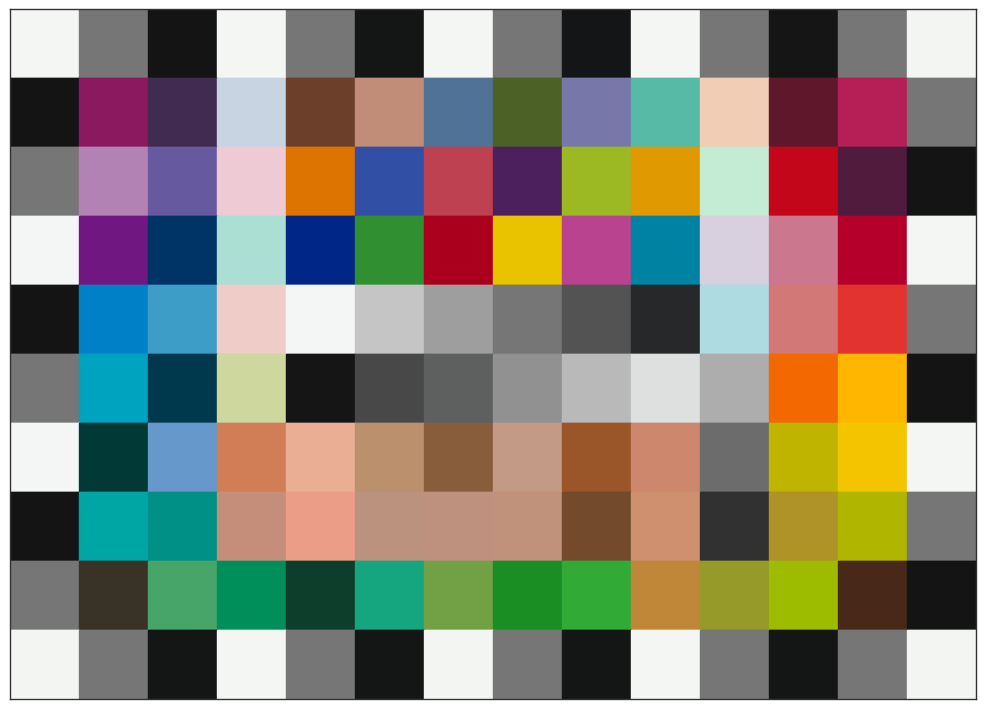

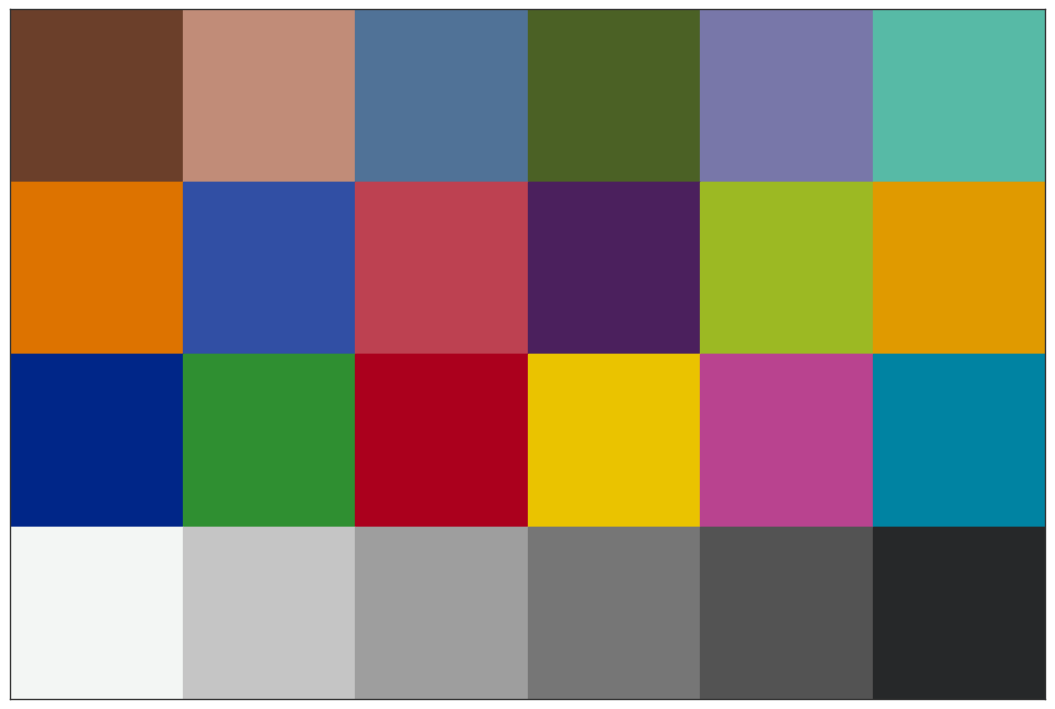

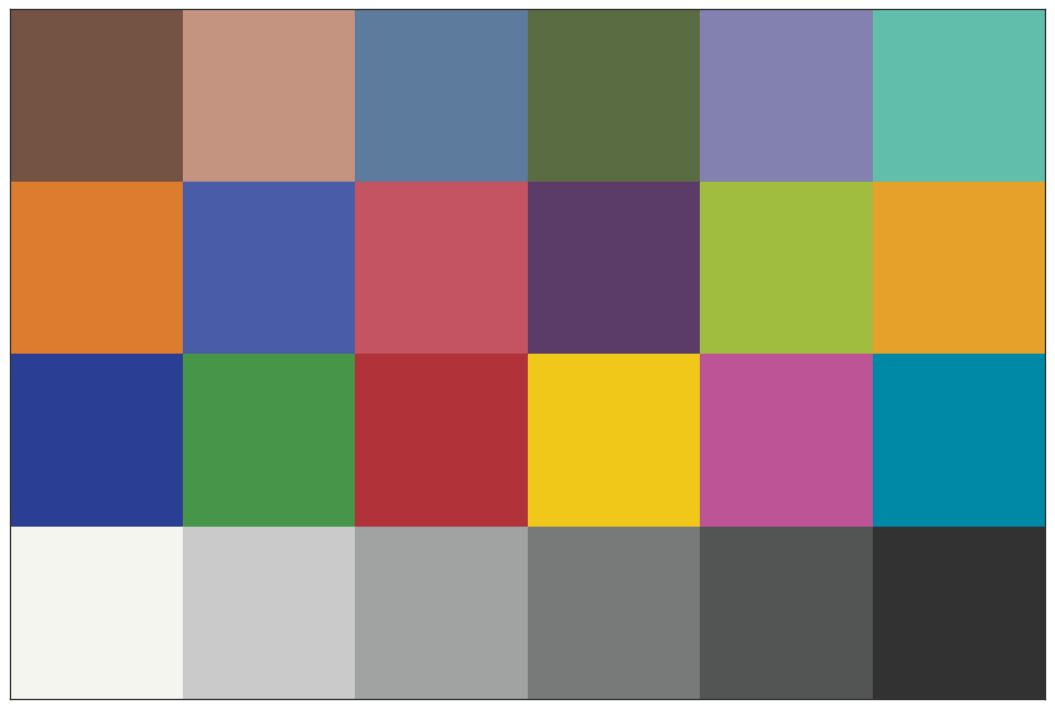

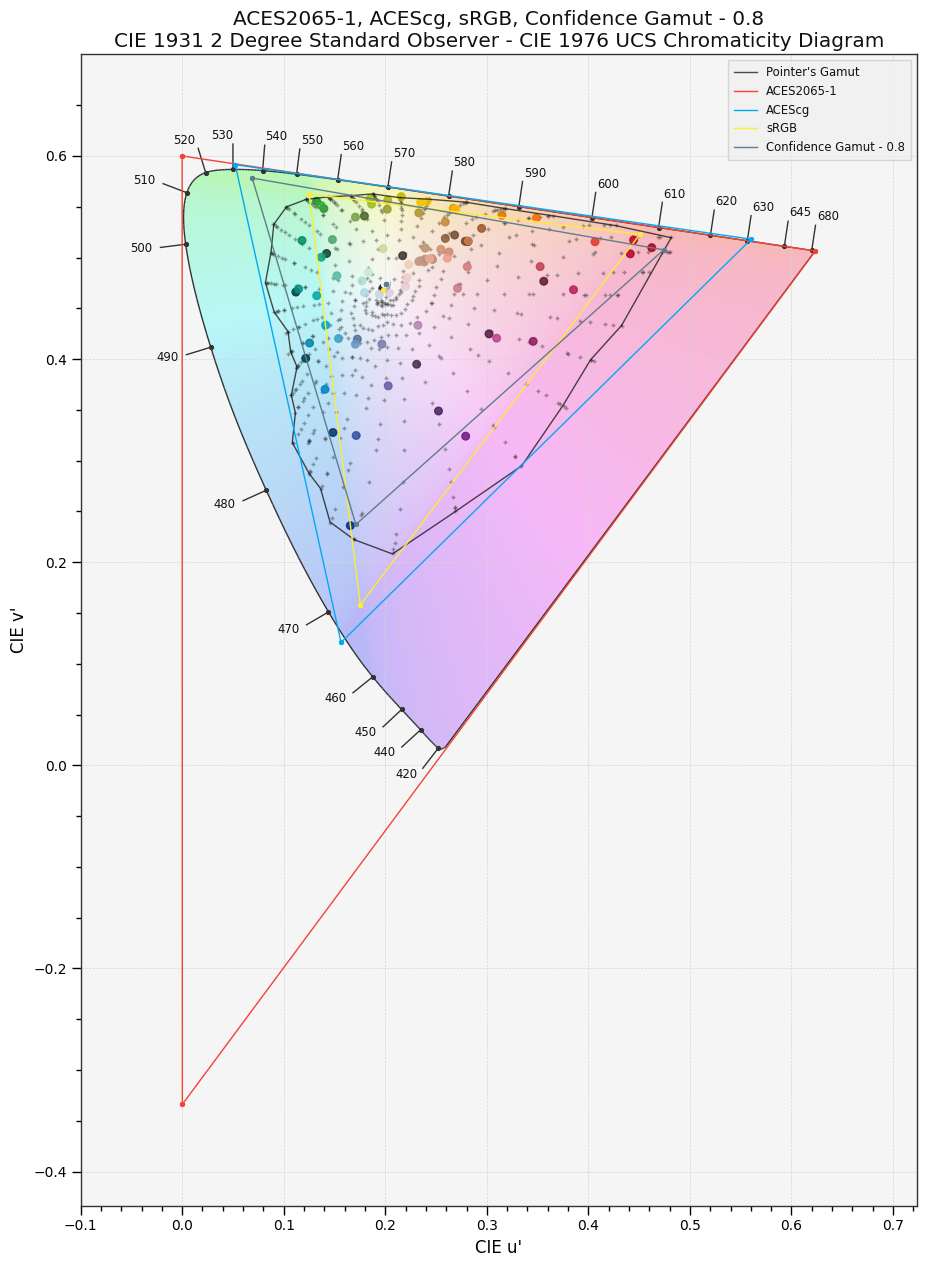

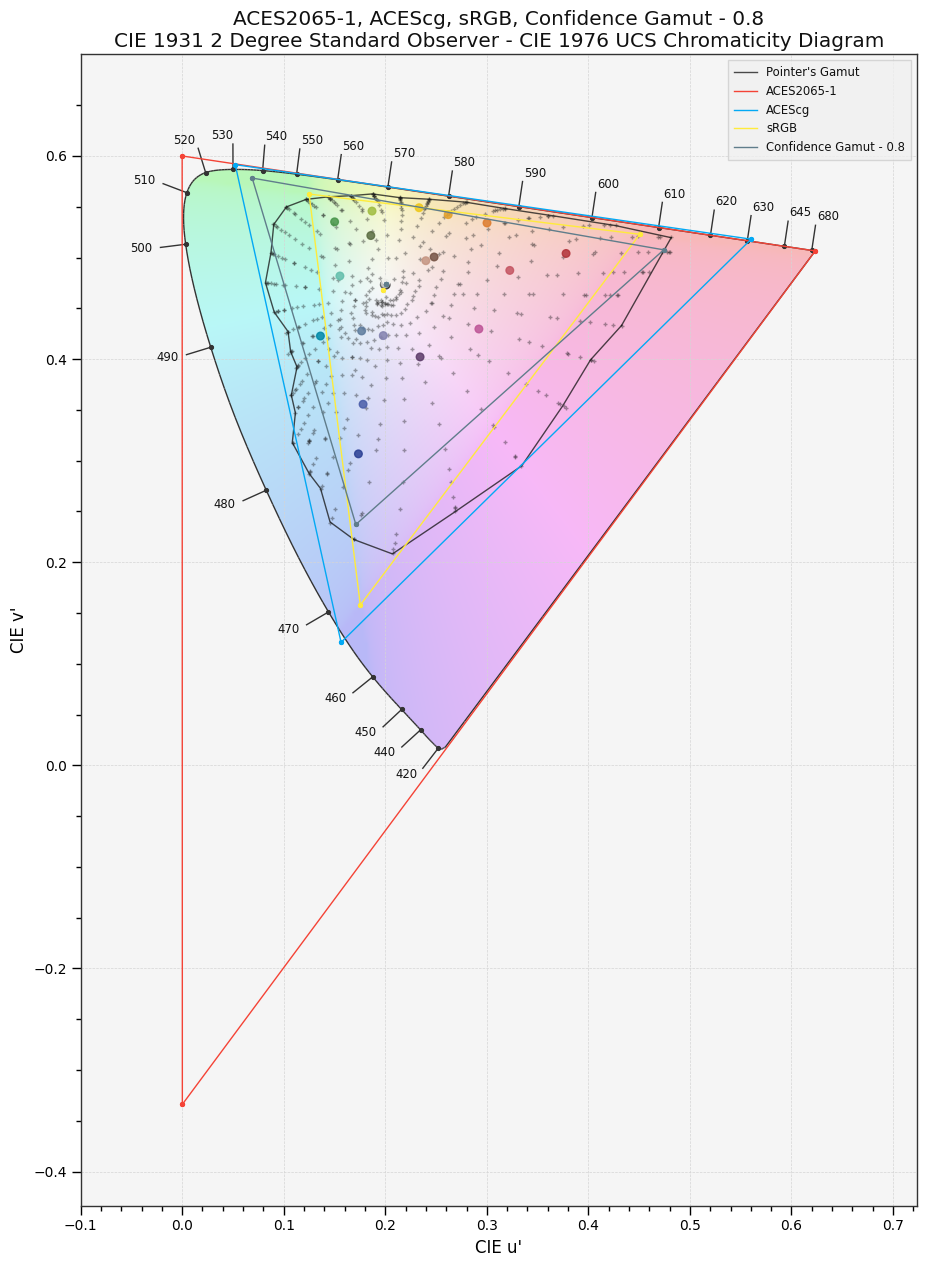

In [4]:
THRESHOLD = 0.8
REFERENCE_SPACE = colour.models.ACES_2065_1_COLOURSPACE
WORKING_SPACE = colour.models.ACES_CG_COLOURSPACE
DISPLAY_SPACE = colour.models.sRGB_COLOURSPACE


def reference_space_to_display_space(RGB):
    return np.clip(
        colour.RGB_to_RGB(
            RGB, REFERENCE_SPACE, DISPLAY_SPACE, apply_cctf_encoding=True), 0,
        1)


SDS_SG = colour.io.read_sds_from_xrite_file('Digital_ColorChecker_SG.txt')

XYZ_SG = [
    colour.sd_to_XYZ(
        sd.copy().align(colour.DEFAULT_SPECTRAL_SHAPE),
        illuminant=colour.ILLUMINANT_SDS['D60']) / 100 for sd in SDS_SG.values()
]

RGB_SG = colour.XYZ_to_RGB(XYZ_SG, REFERENCE_SPACE.whitepoint,
                           REFERENCE_SPACE.whitepoint,
                           REFERENCE_SPACE.XYZ_to_RGB_matrix)

RGB_SG = np.transpose(RGB_SG.reshape([14, 10, 3]), [1, 0, 2])

XYZ_CC24 = [
    colour.sd_to_XYZ(
        sd.copy().align(colour.DEFAULT_SPECTRAL_SHAPE),
        illuminant=colour.ILLUMINANT_SDS['D60']) / 100
    for sd in colour.COLOURCHECKER_SDS['BabelColor Average'].values()
]

RGB_CC24 = colour.XYZ_to_RGB(XYZ_CC24, REFERENCE_SPACE.whitepoint,
                             REFERENCE_SPACE.whitepoint,
                             REFERENCE_SPACE.XYZ_to_RGB_matrix)

RGB_CC24 = RGB_CC24.reshape([4, 6, 3])

colour.write_image(RGB_SG, 'Digital_ColorChecker_SG_AP0.exr')
colour.write_image(RGB_CC24, 'ColorChecker_Classic_AP0.exr')

colour.plotting.plot_multi_colour_swatches(
    reference_space_to_display_space(RGB_SG),
    columns=RGB_SG.shape[1],
    direction='-y')

colour.plotting.plot_multi_colour_swatches(
    reference_space_to_display_space(RGB_SG[1:5, 4:10]),
    columns=6,
    direction='-y')

colour.plotting.plot_multi_colour_swatches(
    reference_space_to_display_space(RGB_CC24),
    columns=6,
    direction='-y')

CONFIDENCE_GAMUT_PRIMARIES = WORKING_SPACE.primaries.copy()
CONFIDENCE_GAMUT_PRIMARIES -= WORKING_SPACE.whitepoint
CONFIDENCE_GAMUT_PRIMARIES *= THRESHOLD
CONFIDENCE_GAMUT_PRIMARIES += WORKING_SPACE.whitepoint

CONFIDENCE_GAMUT = colour.RGB_Colourspace(
    'Confidence Gamut - {0}'.format(THRESHOLD), CONFIDENCE_GAMUT_PRIMARIES,
    WORKING_SPACE.whitepoint)

figure, axes = colour.plotting.plot_RGB_chromaticities_in_chromaticity_diagram_CIE1976UCS(
    RGB_SG,
    colourspace='ACES2065-1',
    colourspaces=['sRGB|ACEScg', CONFIDENCE_GAMUT],
    show_pointer_gamut=True,
    scatter_kwargs={'s': 30},
    diagram_opacity=0.25)

figure, axes = colour.plotting.plot_RGB_chromaticities_in_chromaticity_diagram_CIE1976UCS(
    RGB_CC24,
    colourspace='ACES2065-1',
    colourspaces=['sRGB|ACEScg', CONFIDENCE_GAMUT],
    show_pointer_gamut=True,
    scatter_kwargs={'s': 30},
    diagram_opacity=0.25)
